In [189]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_score, recall_score, f1_score
from torchinfo import summary
import warnings
import os 
warnings.filterwarnings('ignore') 



In [190]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [191]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [192]:
data = datasets.ImageFolder(root='cnn_dataset', transform=transform)

In [193]:
print("Length of clases:",len(data.classes))


Length of clases: 36


In [194]:
# splitting the dataset into train, validation and test sets
torch.manual_seed(45)

trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1
trainSize = int(trainRatio * len(data))
valSize = int(valRatio * len(data))
testSize = len(data) - trainSize - valSize

trainData, valData, testData = random_split(data, [trainSize, valSize, testSize])



In [195]:
batch_size = 32
trainDataLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=4)
valDataLoader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=4)
testDataLoader = DataLoader(testData, batch_size=batch_size, shuffle=False, num_workers=4)



In [196]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.DP1 = nn.Dropout(0.25) 
        self.DP2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 36)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.DP1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.DP1(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.DP2(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [197]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

In [198]:
model = CNN().to(device)

In [199]:
print(model)
summary(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (DP1): Dropout(p=0.25, inplace=False)
  (DP2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)


Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─Linear: 1-6                            401,536
├─Linear: 1-7                            4,644
Total params: 424,996
Trainable params: 424,996
Non-trainable params: 0

In [200]:
learningRate = 0.001
numEpochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)


trainLoss, valLoss = [], []
trainAccuracy, valAccuracy = [], []
bestValidationAccuracy = 0.0
startTime = time.time()
earlyStopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(numEpochs):
    # Training phase
    model.train()
    train_loss, correct_train = 0, 0
    for images, labels in trainDataLoader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / len(trainDataLoader)
    train_accuracy = correct_train / len(trainData)
    trainLoss.append(avg_train_loss)
    trainAccuracy.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss, correct_val = 0, 0
    with torch.no_grad():  
        for images, labels in valDataLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(valDataLoader)
    val_accuracy = correct_val / len(valData)
    valLoss.append(avg_val_loss)
    valAccuracy.append(val_accuracy)

    if val_accuracy>bestValidationAccuracy:
        bestValidationAccuracy = val_accuracy
        if os.path.exists("cnn.pt"):
            os.remove("cnn.pt")
        torch.save(model.state_dict(), f"cn.pt")
        print(f'Saving model at epoch {epoch+1} with validation accuracy {bestValidationAccuracy:.4f}')
    
    print(f"Epoch no. [{epoch+1}/{numEpochs}], "
          f"Train Loss: {avg_train_loss*100:.2f}%, Train Accuracy: {train_accuracy*100:.2f}%, "f"Val Loss: {avg_val_loss*100:.2f}%, Val Accuracy: {val_accuracy*100:.2f}%")
    
    earlyStopping(val_loss)
    if earlyStopping.early_stop:
        print("Stopping training")
        break
    
endTime = time.time()
totalTime = endTime - startTime
formatedTime = time.strftime("%Hh:%Mm:%Ss", time.gmtime(t))
print(f"Training completed in {formatedTime}")


Saving model at epoch 1 with validation accuracy 0.8695
Epoch no. [1/10], Train Loss: 107.84%, Train Accuracy: 66.00%, Val Loss: 37.57%, Val Accuracy: 86.95%
Saving model at epoch 2 with validation accuracy 0.8830
Epoch no. [2/10], Train Loss: 68.80%, Train Accuracy: 76.96%, Val Loss: 33.15%, Val Accuracy: 88.30%
Saving model at epoch 3 with validation accuracy 0.8915
Epoch no. [3/10], Train Loss: 58.96%, Train Accuracy: 80.28%, Val Loss: 29.57%, Val Accuracy: 89.15%
Saving model at epoch 4 with validation accuracy 0.8952
Epoch no. [4/10], Train Loss: 50.83%, Train Accuracy: 82.89%, Val Loss: 27.79%, Val Accuracy: 89.52%
Saving model at epoch 5 with validation accuracy 0.9057
Epoch no. [5/10], Train Loss: 45.35%, Train Accuracy: 84.55%, Val Loss: 26.48%, Val Accuracy: 90.57%
Saving model at epoch 6 with validation accuracy 0.9067
Epoch no. [6/10], Train Loss: 42.10%, Train Accuracy: 85.42%, Val Loss: 25.21%, Val Accuracy: 90.67%
Epoch no. [7/10], Train Loss: 40.17%, Train Accuracy: 85.

In [201]:

model.eval()
testLoss = 0.0
correctPredictions = 0
predictions = []
yTrue = []


with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        testLoss += loss.item()  

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correctPredictions += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        yTrue.extend(labels.cpu().numpy())


testLoss /= len(testDataLoader)
test_accuracy = correctPredictions / len(testData)

print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")


Test Loss: 0.2513, Test Accuracy: 90.19%


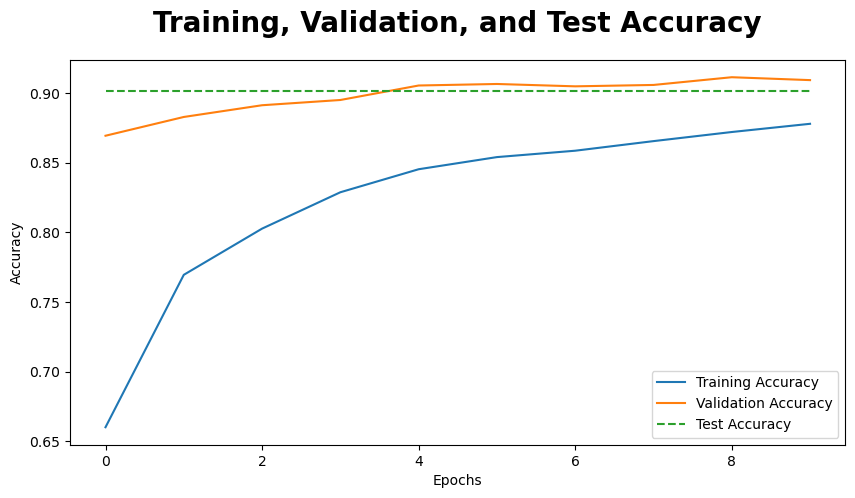

In [202]:
epochs = len(trainAccuracy)
test_accuracies = [test_accuracy] * epochs  

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), trainAccuracy, label='Training Accuracy')
plt.plot(range(epochs), valAccuracy, label='Validation Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy',fontsize=20,pad=20,weight='bold')
plt.legend()
plt.show()


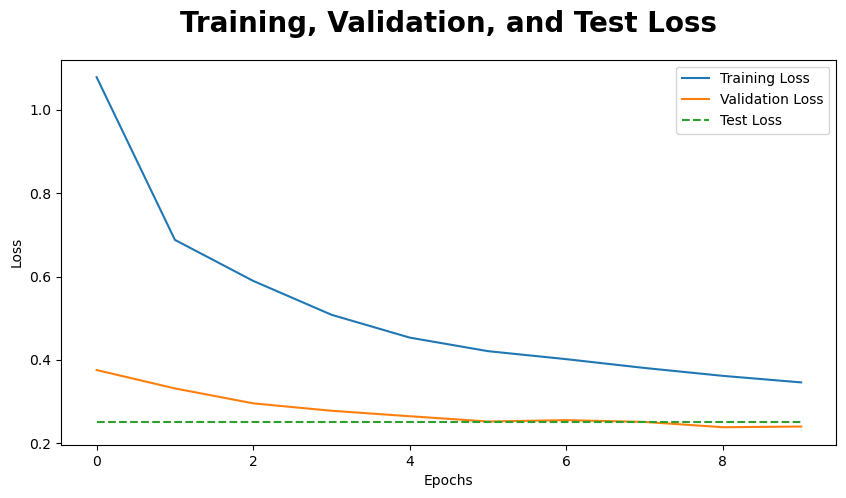

In [203]:
testLosses = [testLoss] * epochs  

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), trainLoss, label='Training Loss')
plt.plot(range(epochs), valLoss, label='Validation Loss')
plt.plot(range(epochs), testLosses, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss',fontsize=20,pad=20,weight='bold')
plt.legend()
plt.show()


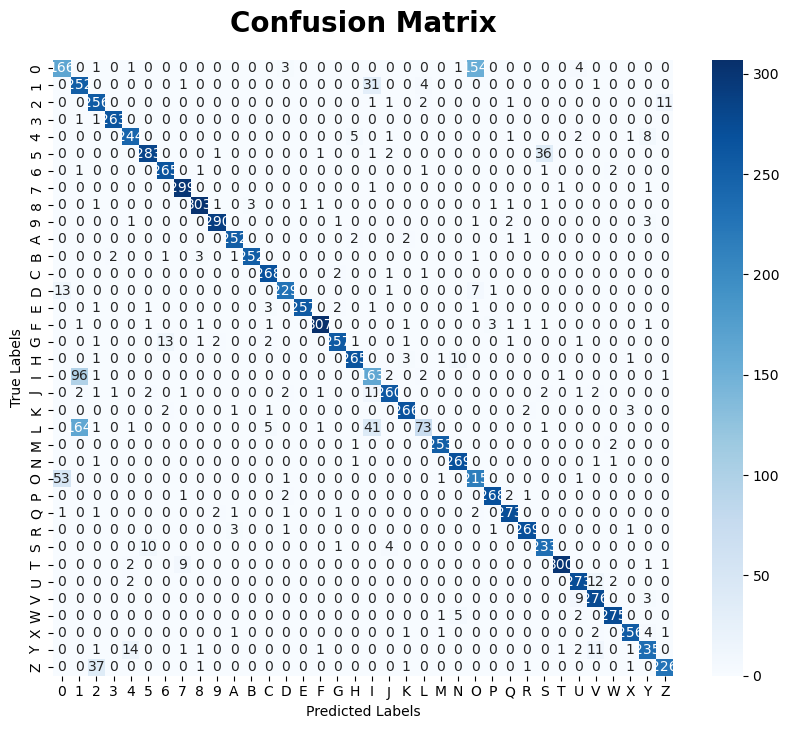

In [204]:
conf_matrix = confusion_matrix(yTrue, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.classes, yticklabels=data.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix',fontsize=20,pad=20,weight='bold')
plt.show()


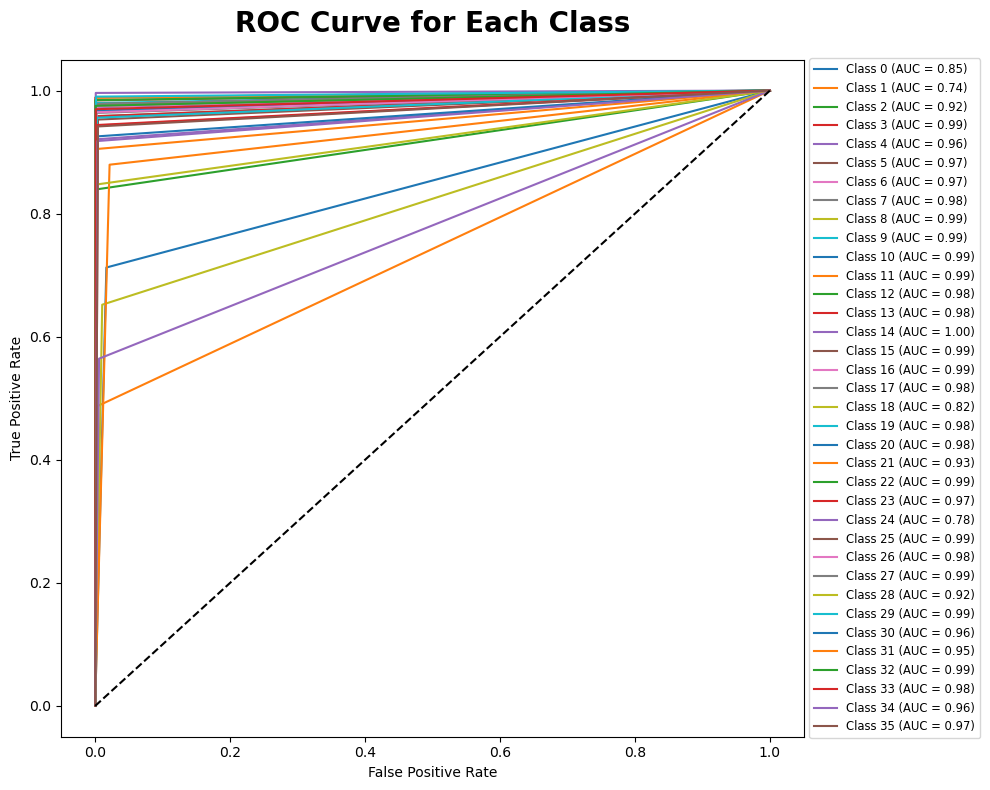

In [205]:
n_classes = len(data.classes)
y_true_binarized = label_binarize(predictions, classes=range(n_classes))
y_score_binarized = label_binarize(yTrue, classes=range(n_classes)) 

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class',fontsize=20,pad=20,weight='bold')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='small')
plt.tight_layout()  
plt.show()


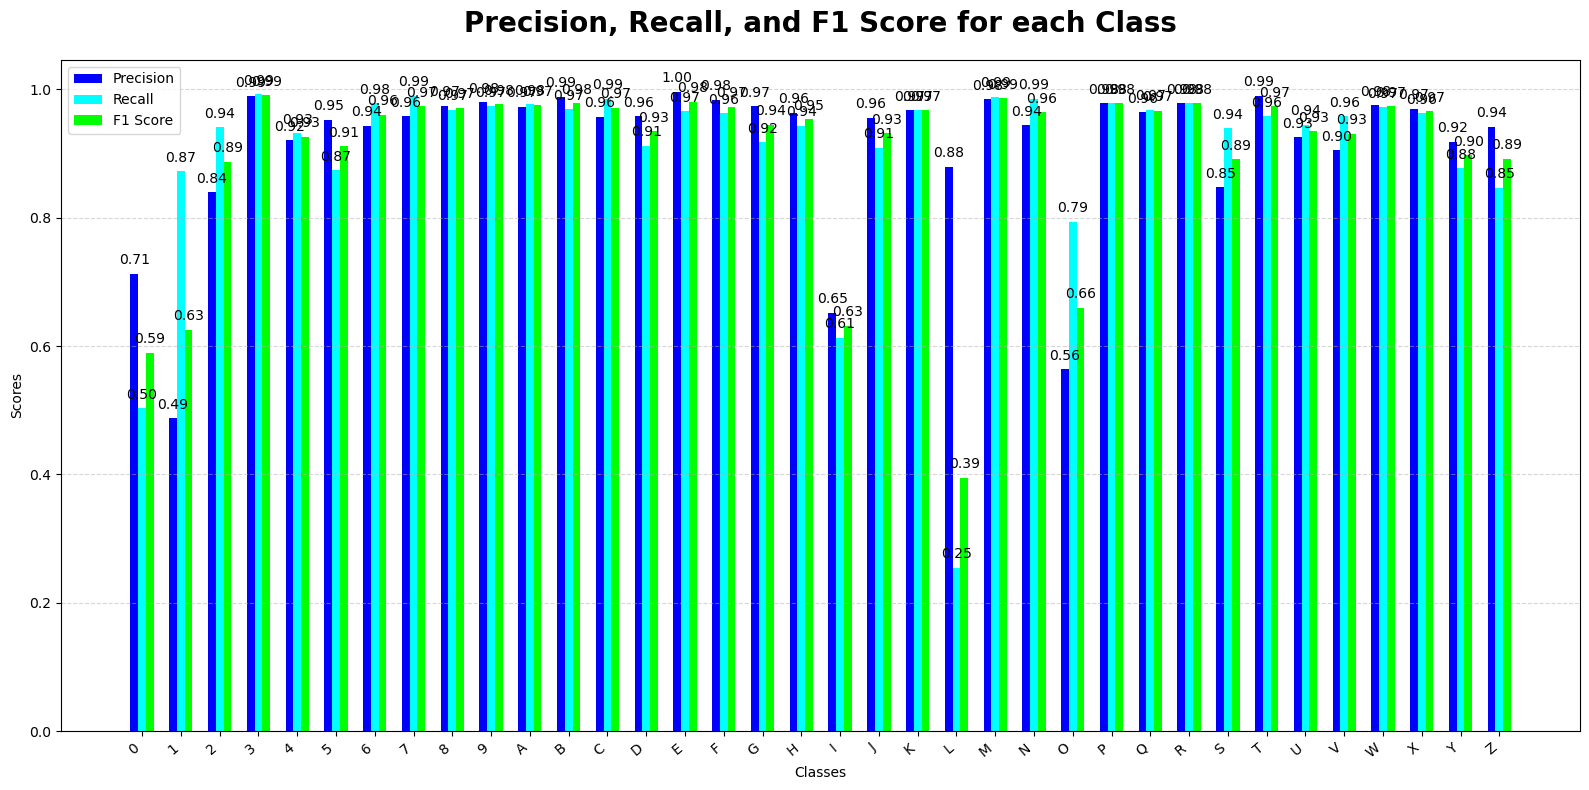

In [206]:

precision = precision_score(yTrue, predictions, average=None)
recall = recall_score(yTrue, predictions, average=None)
f1 = f1_score(yTrue, predictions, average=None)

class_labels = data.classes

x = np.arange(len(class_labels))
width = 0.20

fig, ax = plt.subplots(figsize=(16, 8))  
bars1 = ax.bar(x - width, precision, width, label='Precision', color='blue')
bars2 = ax.bar(x, recall, width, label='Recall', color='cyan')
bars3 = ax.bar(x + width, f1, width, label='F1 Score', color='lime')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for each Class',fontsize=20,pad=20,weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=40, ha='right')
ax.legend()


for bars in [bars1, bars2, bars3]:
    for i, bar in enumerate(bars):
        yval = bar.get_height()

        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')


ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [207]:
i = 0
for c in data.classes:
    print(f"Class {c} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")
    i+=1

Class 0 - Precision: 0.7124, Recall: 0.5030, F1 Score: 0.5897
Class 1 - Precision: 0.4874, Recall: 0.8720, F1 Score: 0.6253
Class 2 - Precision: 0.8393, Recall: 0.9412, F1 Score: 0.8873
Class 3 - Precision: 0.9887, Recall: 0.9925, F1 Score: 0.9906
Class 4 - Precision: 0.9208, Recall: 0.9313, F1 Score: 0.9260
Class 5 - Precision: 0.9529, Recall: 0.8735, F1 Score: 0.9114
Class 6 - Precision: 0.9431, Recall: 0.9779, F1 Score: 0.9601
Class 7 - Precision: 0.9583, Recall: 0.9901, F1 Score: 0.9739
Class 8 - Precision: 0.9743, Recall: 0.9681, F1 Score: 0.9712
Class 9 - Precision: 0.9797, Recall: 0.9732, F1 Score: 0.9764
Class A - Precision: 0.9730, Recall: 0.9767, F1 Score: 0.9749
Class B - Precision: 0.9882, Recall: 0.9692, F1 Score: 0.9786
Class C - Precision: 0.9571, Recall: 0.9853, F1 Score: 0.9710
Class D - Precision: 0.9582, Recall: 0.9124, F1 Score: 0.9347
Class E - Precision: 0.9961, Recall: 0.9662, F1 Score: 0.9809
Class F - Precision: 0.9840, Recall: 0.9624, F1 Score: 0.9731
Class G 